In [1]:
from bdsf import process_image
import pandas as pd
import xarray as xr
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits

import os

from daskms import xds_from_ms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 18

In [3]:
# data_dir = '/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/examples/data/target_obs_16A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD'
# data_dir = '/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/examples/data/target_obs_64A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD'
# data_dir = '/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/data/target_obs_64A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD'
# data_dir = '/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/data/target_obs_16A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD'
# data_dir = '/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/data/target_obs_16A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_01000AST_1SAT_0GRD'
# data_dir = '/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/data/target_obs_64A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_01000AST_1SAT_0GRD'
data_dir = '/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/data/target_obs_64A_450T-0440-1338_004I_001F-1.227e+09-1.227e+09_01000AST_1SAT_0GRD'

In [4]:
data_type = "ideal"
data_type = "flag"

In [5]:
# noise_data = fits.getdata(os.path.join(data_dir, f"{data_type}.resid.fits"))
# noise = np.nanstd(noise_data[0, 0])

noise_data = fits.getdata(os.path.join(data_dir, f"{data_type}.gauss_resid.fits"))
noise = np.nanstd(noise_data[0, 0])

img, hdr = fits.getdata(os.path.join(data_dir, f"{data_type}.fits"), header=True)
        
df = pd.read_csv(os.path.join(data_dir, f"{data_type}.pybdsf.csv"), skiprows=5)

xds = xr.open_zarr(data_dir)

keys1 = [
    " Isl_id",
    " RA",
    " E_RA",
    " DEC",
    " E_DEC",
    " Total_flux",
    " E_Total_flux",
    " Maj",
    " E_Maj",
    " Min",
    " E_Min",
    " PA",
    " E_PA",
]
keys2 = [" RA", " DEC", " Total_flux", " E_Total_flux"]
image_df = (
    df[df[" Total_flux"] > 1e-5][keys1]
    .sort_values(" Total_flux")
    .reset_index()[keys1]
)
true_df = (
    pd.DataFrame(
        data=np.concatenate(
            [
                xds.ast_radec.data,
                xds.ast_I.data[:, 0, :],
                np.zeros((xds.ast_I.data.shape[0], 1)),
            ],
            axis=1,
        ),
        columns=[" RA", " DEC", " Total_flux", " E_Total_flux"],
    )
    .sort_values(" Total_flux")
    .reset_index()[keys2]
)

c = SkyCoord(ra=image_df[" RA"], dec=image_df[" DEC"], unit="deg")
catalog = SkyCoord(ra=true_df[" RA"], dec=true_df[" DEC"], unit="deg")
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

true_df1 = true_df.iloc[idx].reset_index()[keys2]
image_df1 = image_df[keys2]
error_df = np.abs((image_df1 - true_df1))
error_df = pd.DataFrame(
    data=np.abs((image_df1 - true_df1)[[" RA", " DEC"]] * 3600).values,
    columns=["E_RA [as]", "E_DEC [as]"],
)
error_df["E_Total_flux [%]"] = (
    100 * (image_df1 - true_df1)[" Total_flux"] / true_df1[" Total_flux"]
)
error_df[["RA [deg]", "DEC [deg]"]] = true_df1[[" RA", " DEC"]]
error_df["Total_flux_true [mJy]"] = 1e3 * true_df1[" Total_flux"]
error_df["Total_flux_image [mJy]"] = 1e3 * image_df1[" Total_flux"]
error_df["SNR"] = image_df1[" Total_flux"] / noise
error_df["Total_flux_std [mJy]"] = 1e3 * image_df1[" E_Total_flux"]
error_df["Image_noise [mJy/beam]"] = 1e3 * noise
error_df["E_RADEC [as]"] = d2d.arcsec

beam_size = np.sqrt(hdr['BMAJ']*hdr['BMIN'])*3600

mask = d2d.arcsec < 1.*beam_size
keys = [
    "RA [deg]",
    "E_RA [as]",
    "DEC [deg]",
    "E_DEC [as]",
    "Total_flux_true [mJy]",
    "E_Total_flux [%]",
    "E_RADEC [as]",
    "Total_flux_image [mJy]",
    "Total_flux_std [mJy]",
    "SNR",
    "Image_noise [mJy/beam]",
]
error_df = error_df[keys].iloc[mask]

In [6]:
beam_size, 1e3*noise

(9.756869776460004, 32.71067142486572)

In [7]:
strng_src = xds.ast_I[:,0,0] > 5.0e-3
c = SkyCoord(ra=xds.ast_radec[strng_src,0].data.compute(), dec=xds.ast_radec[strng_src,1].data.compute(), frame='icrs', unit='deg')

Set OBSGEO-B to   -30.713200 from OBSGEO-[XYZ].
Set OBSGEO-H to     1046.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


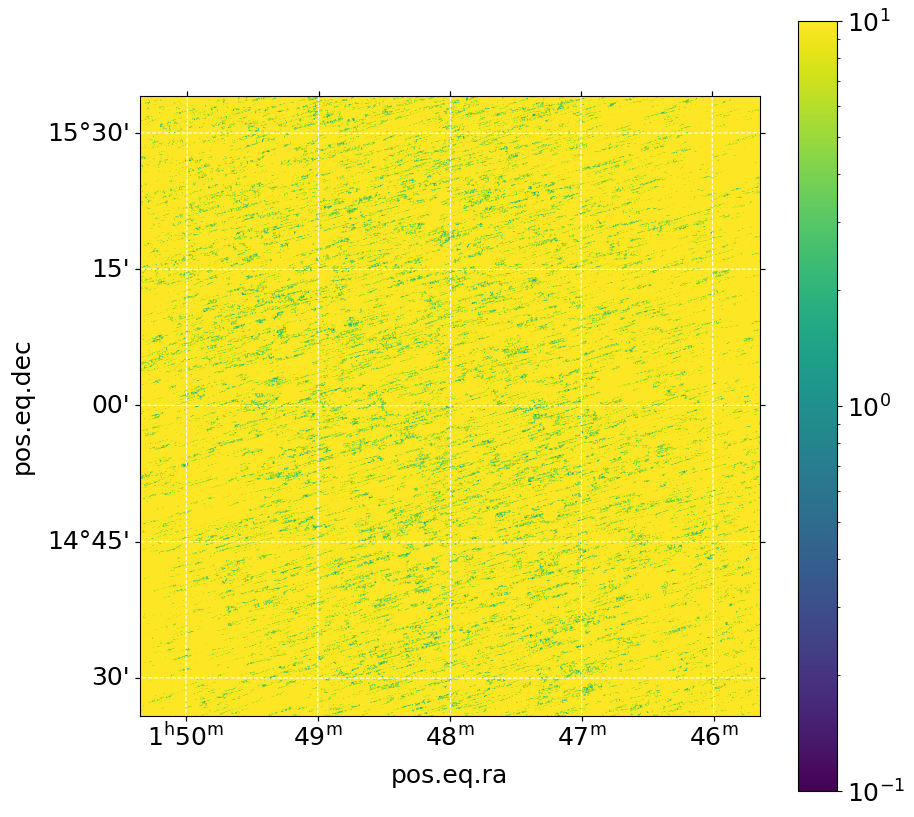

In [8]:
wcs = WCS(hdr)
plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs.celestial) 
plt.imshow(np.abs(np.squeeze(img))*1e3, origin='lower', vmin=1e-1, vmax=1e1, norm='log') 
plt.grid(color='white', ls='dashed')
plt.colorbar()
# ax.scatter(c.ra, c.dec, transform=ax.get_transform('fk4'), s=50, edgecolor='white', facecolor='none')
# ax.set_xlim(800, 1300)
# ax.set_ylim(800, 1300)

In [9]:
error_df

,RA [deg],E_RA [as],DEC [deg],E_DEC [as],Total_flux_true [mJy],E_Total_flux [%],E_RADEC [as],Total_flux_image [mJy],Total_flux_std [mJy],SNR,Image_noise [mJy/beam]
64,26.828429,1.645139,15.018368,4.270097,518.273369,-77.202877,4.556148,118.151417,35.450034,3.612014,32.710671
112,27.120374,4.845940,14.503275,3.497776,248.472152,-43.572137,5.851894,140.207525,37.679078,4.286293,32.710671
237,26.725702,0.264367,15.452025,4.875542,0.529902,34919.603539,4.882196,185.569692,62.211721,5.673063,32.710671
270,26.739236,0.625688,14.677877,2.973174,0.569290,34249.111334,3.034158,195.546209,55.075555,5.978055,32.710671
407,26.509696,5.122051,15.410726,5.166124,13.399733,1726.350432,7.146428,244.726085,92.864809,7.481537,32.710671
423,27.159504,7.146898,15.182782,2.337989,0.965337,25840.499350,7.282904,250.413142,61.274791,7.655396,32.710671
426,26.695973,7.708002,14.446058,2.640625,0.569279,44150.062676,7.917605,251.906167,70.627883,7.701039,32.710671
466,27.041891,4.070020,15.230154,0.400854,0.809170,33378.827045,3.947479,270.900582,59.006464,8.281719,32.710671
498,27.033255,1.259159,14.499683,1.658887,0.394532,73126.427159,2.058639,288.901538,74.932478,8.832027,32.710671
533,26.509696,9.424257,15.410726,1.891191,13.399733,2153.027121,9.280148,301.899622,100.094183,9.229392,32.710671


In [10]:
error_df["SNR"].min()

3.612014438322249

In [11]:
ms_xds = xds_from_ms(data_dir+".ms")[0]
ms_xds.FLAG.data.mean().compute()*100

0.0

In [18]:
xds.noise_std.data.mean().compute(), np.sqrt(xds.vis_obs.size)

(0.6496226361342333, 952.4704719832527)

In [19]:
(1-xds.flags.mean().data.compute())

1.0

In [23]:
import dask.array as da

In [31]:
xds.vis_obs.size

907200

In [43]:
np.sqrt((1-xds.flags.mean())*xds.vis_obs.size).data.compute()

952.4704719832527

In [45]:
np.sqrt((1-xds.flags.mean())*xds.vis_obs.size).compute()

<xarray.DataArray 'flags' ()>
array(952.47047198)

In [32]:
(xds.noise_std.mean()/da.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).compute().data*1e3

0.8195710433132081

In [34]:
(xds.noise_std.mean()/np.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).compute().data*1e3

0.6820396592259457

In [35]:
(xds.noise_std.mean()/da.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).data.compute()*1e3

1.3511947786375866

In [37]:
(xds.noise_std.mean()/np.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).data.compute()*1e3

0.6820396592259457

In [54]:
(xds.noise_std.mean()/da.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).compute().data*1e3

0.8195710433132081

In [55]:
(xds.noise_std.mean()/np.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).compute().data*1e3

0.6820396592259457

In [56]:
(xds.noise_std.mean()/da.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).data.compute()*1e3

0.6820396592259457

In [57]:
(xds.noise_std.mean()/np.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).data.compute()*1e3

0.8195710433132081

In [30]:
(xds.noise_std.mean()/np.sqrt(xds.vis_obs.size)).compute().data*1e3, noise*1e3, (xds.noise_std.mean()/da.sqrt((1-xds.flags.mean())*xds.vis_obs.size)).compute().data*1e3

(0.6820396592259457, 32.71067142486572, 1.3511947786375866)

In [14]:
xds.flags.data.compute().sum()

0

In [17]:
xds.flags.mean().data.compute()*100

0.0

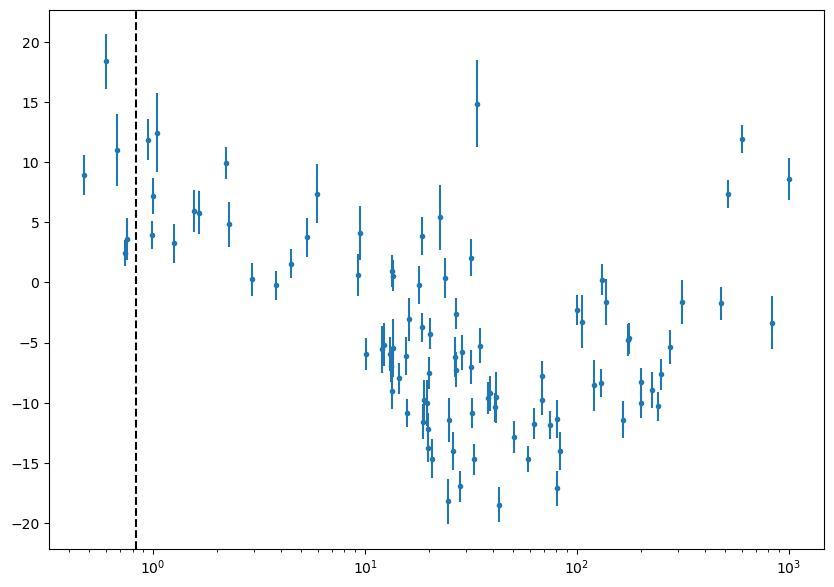

In [23]:
plt.figure(figsize=(10,7))
plt.errorbar(error_df["Total_flux_true [mJy]"], error_df["Total_flux_image [mJy]"]-error_df["Total_flux_true [mJy]"], error_df["Total_flux_std [mJy]"], fmt='.')
plt.xscale("log")
plt.axvline(noise*1e3, ls="dashed", color="k")

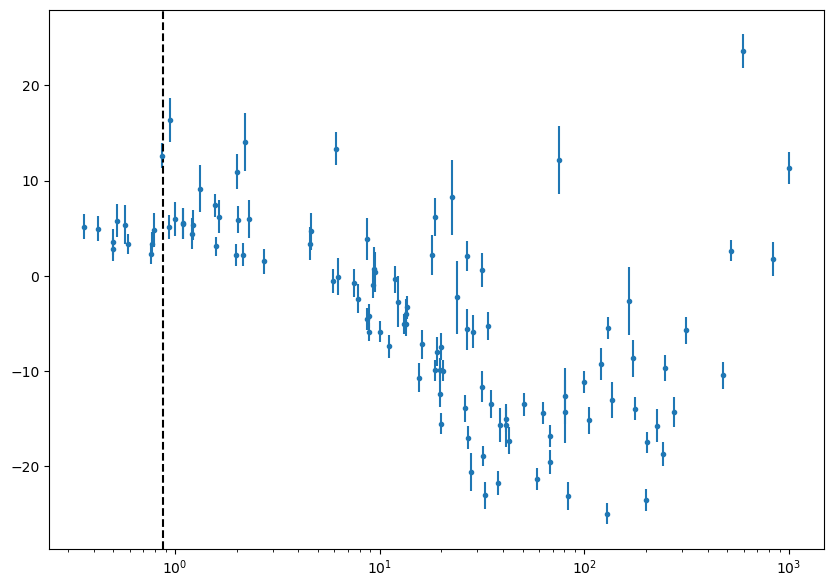

In [639]:
plt.figure(figsize=(10,7))
plt.errorbar(error_df["Total_flux_true [mJy]"], error_df["Total_flux_image [mJy]"]-error_df["Total_flux_true [mJy]"], error_df["Total_flux_std [mJy]"], fmt='.')
plt.xscale("log")
plt.axvline(noise*1e3, ls="dashed", color="k")

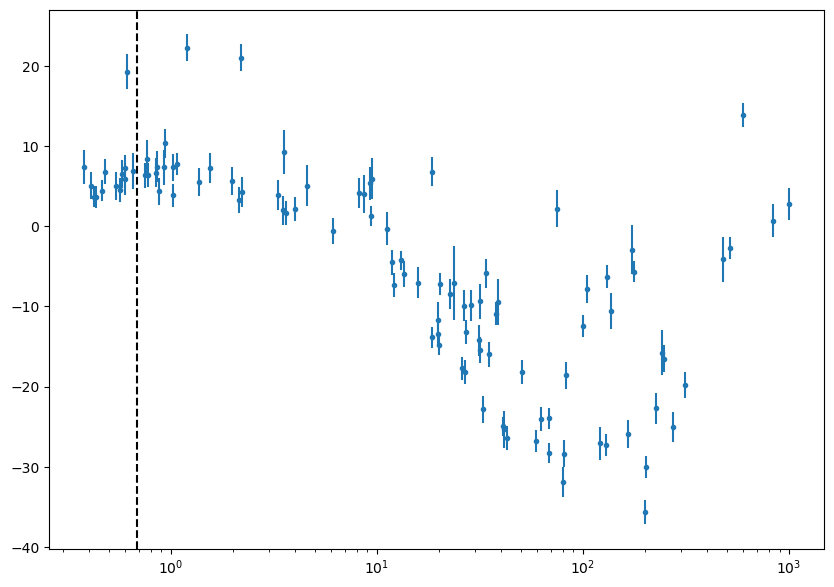

In [601]:
plt.figure(figsize=(10,7))
plt.errorbar(error_df["Total_flux_true [mJy]"], error_df["Total_flux_image [mJy]"]-error_df["Total_flux_true [mJy]"], error_df["Total_flux_std [mJy]"], fmt='.')
plt.xscale("log")
plt.axvline(noise*1e3, ls="dashed", color="k")

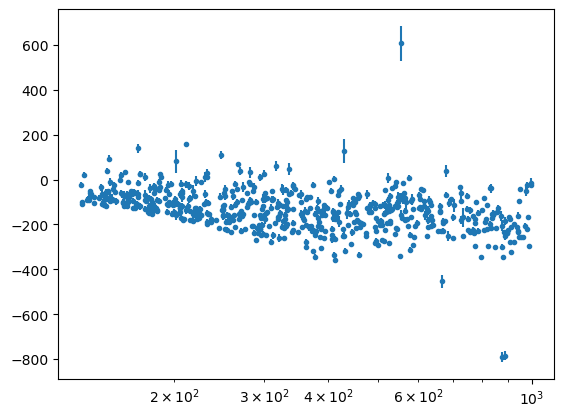

In [524]:
plt.errorbar(error_df["Total_flux_true [mJy]"], error_df["Total_flux_image [mJy]"]-error_df["Total_flux_true [mJy]"], error_df["Total_flux_std [mJy]"], fmt='.')
plt.xscale("log")

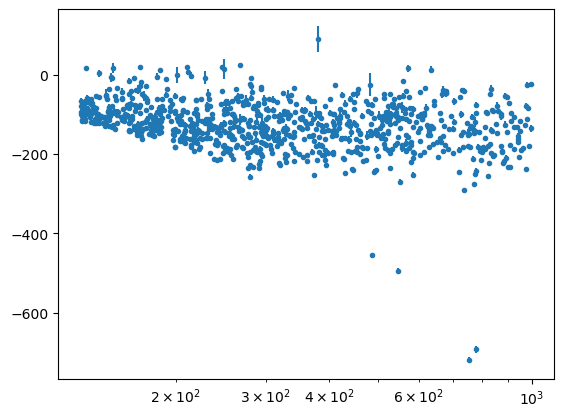

In [493]:
plt.errorbar(error_df["Total_flux_true [mJy]"], error_df["Total_flux_image [mJy]"]-error_df["Total_flux_true [mJy]"], error_df["Total_flux_std [mJy]"], fmt='.')
plt.xscale("log")

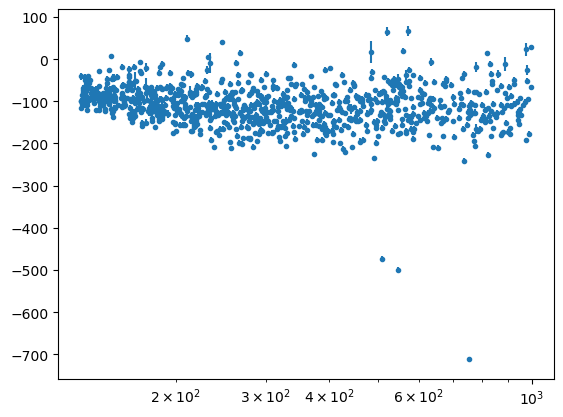

In [484]:
plt.errorbar(error_df["Total_flux_true [mJy]"], error_df["Total_flux_image [mJy]"]-error_df["Total_flux_true [mJy]"], error_df["Total_flux_std [mJy]"], fmt='.')
plt.xscale("log")

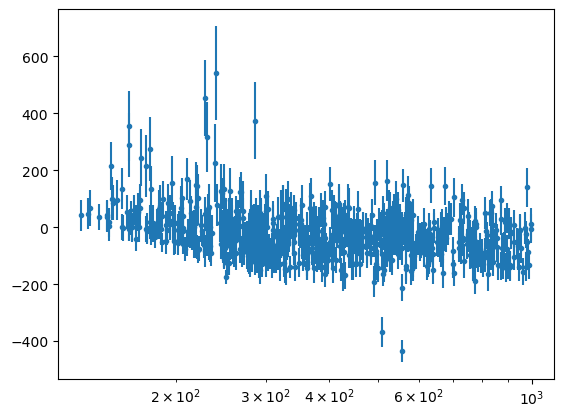

In [475]:
plt.errorbar(error_df["Total_flux_true [mJy]"], error_df["Total_flux_image [mJy]"]-error_df["Total_flux_true [mJy]"], error_df["Total_flux_std [mJy]"], fmt='.')
plt.xscale("log")

In [422]:
xds

<xarray.Dataset>
Dimensions:          (freq: 1, ant: 64, bl: 2016, enu: 3, time_fine: 57600,
                      uvw: 3, xyz: 3, ast_src: 100, lmn: 3, radec: 2, geo: 3,
                      time: 450, sat_src: 1, orbit: 4)
Coordinates:
  * ant              (ant) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * bl               (bl) int64 0 1 2 3 4 5 6 ... 2010 2011 2012 2013 2014 2015
  * enu              (enu) <U5 'east' 'north' 'up'
  * freq             (freq) float64 1.227e+09
  * geo              (geo) <U9 'latitude' 'longitude' 'elevation'
  * lmn              (lmn) <U1 'l' 'm' 'n'
  * radec            (radec) <U3 'ra' 'dec'
  * time             (time) float64 440.0 442.0 444.0 ... 1.336e+03 1.338e+03
  * time_fine        (time_fine) float64 439.0 439.0 ... 1.339e+03 1.339e+03
  * uvw              (uvw) <U1 'u' 'v' 'w'
  * xyz              (xyz) <U1 'x' 'y' 'z'
Dimensions without coordinates: ast_src, sat_src, orbit
Data variables: (12/20)
    SEFD             (freq) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    antenna1         (bl) int64 dask.array<chunksize=(2016,), meta=np.ndarray>
    antenna2         (bl) int64 dask.array<chunksize=(2016,), meta=np.ndarray>
    ants_enu         (ant, enu) float64 dask.array<chunksize=(64, 3), meta=np.ndarray>
    ants_uvw         (time_fine, ant, uvw) float64 dask.array<chunksize=(3200, 64, 3), meta=np.ndarray>
    ants_xyz         (time_fine, ant, xyz) float64 dask.array<chunksize=(3200, 64, 3), meta=np.ndarray>
    ...               ...
    rfi_sat_ang_sep  (sat_src, time_fine, ant) float64 dask.array<chunksize=(1, 3200, 64), meta=np.ndarray>
    rfi_sat_orbit    (sat_src, orbit) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    rfi_sat_xyz      (sat_src, time_fine, xyz) float64 dask.array<chunksize=(1, 3200, 3), meta=np.ndarray>
    vis_ast          (time_fine, bl, freq) complex128 dask.array<chunksize=(3200, 2016, 1), meta=np.ndarray>
    vis_obs          (time, bl, freq) complex128 dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
    vis_rfi          (time_fine, bl, freq) complex128 dask.array<chunksize=(3200, 2016, 1), meta=np.ndarray>
Attributes: (12/18)
    chan_width:     209000.0
    dish_diameter:  13.965
    int_time:       2.0
    n_ant:          64
    n_ast_src:      100
    n_bl:           2016
    ...             ...
    target_dec:     15.0
    target_ra:      27.0
    tel_elevation:  1050.0
    tel_latitude:   -30.0
    tel_longitude:  21.0
    tel_name:       MeerKAT

In [440]:
xds

<xarray.Dataset>
Dimensions:          (freq: 1, ant: 64, bl: 2016, enu: 3, time_fine: 57600,
                      uvw: 3, xyz: 3, ast_src: 100, lmn: 3, radec: 2, geo: 3,
                      time: 450, sat_src: 1, orbit: 4)
Coordinates:
  * ant              (ant) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * bl               (bl) int64 0 1 2 3 4 5 6 ... 2010 2011 2012 2013 2014 2015
  * enu              (enu) <U5 'east' 'north' 'up'
  * freq             (freq) float64 1.227e+09
  * geo              (geo) <U9 'latitude' 'longitude' 'elevation'
  * lmn              (lmn) <U1 'l' 'm' 'n'
  * radec            (radec) <U3 'ra' 'dec'
  * time             (time) float64 440.0 442.0 444.0 ... 1.336e+03 1.338e+03
  * time_fine        (time_fine) float64 439.0 439.0 ... 1.339e+03 1.339e+03
  * uvw              (uvw) <U1 'u' 'v' 'w'
  * xyz              (xyz) <U1 'x' 'y' 'z'
Dimensions without coordinates: ast_src, sat_src, orbit
Data variables: (12/24)
    SEFD             (freq) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    antenna1         (bl) int64 dask.array<chunksize=(2016,), meta=np.ndarray>
    antenna2         (bl) int64 dask.array<chunksize=(2016,), meta=np.ndarray>
    ants_enu         (ant, enu) float64 dask.array<chunksize=(64, 3), meta=np.ndarray>
    ants_uvw         (time_fine, ant, uvw) float64 dask.array<chunksize=(3200, 64, 3), meta=np.ndarray>
    ants_xyz         (time_fine, ant, xyz) float64 dask.array<chunksize=(3200, 64, 3), meta=np.ndarray>
    ...               ...
    vis_obs          (time, bl, freq) complex128 dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
    vis_rfi          (time_fine, bl, freq) complex128 dask.array<chunksize=(3200, 2016, 1), meta=np.ndarray>
    vis_corrected    (time, bl, freq) complex128 dask.array<chunksize=(450, 2016, 1), meta=np.ndarray>
    vis_calibrated   (time, bl, freq) complex128 dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
    flags            (time, bl, freq) bool dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
    vis_model        (time, bl, freq) complex128 dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
Attributes: (12/18)
    chan_width:     209000.0
    dish_diameter:  13.965
    int_time:       2.0
    n_ant:          64
    n_ast_src:      100
    n_bl:           2016
    ...             ...
    target_dec:     15.0
    target_ra:      27.0
    tel_elevation:  1050.0
    tel_latitude:   -30.0
    tel_longitude:  21.0
    tel_name:       MeerKAT

In [444]:
xds.flags.mean().compute()

<xarray.DataArray 'flags' ()>
array(0.892306)

In [423]:
import dask.array as da
import dask

In [424]:
(("time", "bl", "freq"), da.zeros((xds.n_time, xds.n_bl, xds.n_freq), dtype=complex))

(('time', 'bl', 'freq'),
 dask.array<zeros_like, shape=(450, 2016, 1), dtype=complex128, chunksize=(450, 2016, 1), chunktype=numpy.ndarray>)

In [425]:
xds = xds.assign(vis_corrected=(("time", "bl", "freq"), da.zeros((xds.n_time, xds.n_bl, xds.n_freq), dtype=complex)))

In [426]:
a1 = xds.antenna1
a2 = xds.antenna2

In [427]:
gains_bl = xds.gains_ants[:,a1]*np.conjugate(xds.gains_ants[:,a2])
gains_bl = xr.DataArray(gains_bl.data.reshape(xds.n_time, xds.n_int_samples, xds.n_bl, xds.n_freq).mean(axis=1), 
                        coords=(xds.time, xds.bl, xds.freq), name="gains_bl")
vis_cal = xds.vis_obs / gains_bl

In [428]:
vis_ast = xr.DataArray(xds.vis_ast.data.reshape(xds.n_time, xds.n_int_samples, xds.n_bl, xds.n_freq).mean(axis=1),
                       coords=(xds.time, xds.bl, xds.freq))

In [429]:
xds = xds.assign(vis_calibrated=vis_cal)

In [430]:
xds = xds.assign(flags=np.abs(vis_cal-vis_ast)>3*xds.noise_std*np.sqrt(2))

In [431]:
xds = xds.assign(vis_model=vis_ast)

In [432]:
xds

<xarray.Dataset>
Dimensions:          (freq: 1, ant: 64, bl: 2016, enu: 3, time_fine: 57600,
                      uvw: 3, xyz: 3, ast_src: 100, lmn: 3, radec: 2, geo: 3,
                      time: 450, sat_src: 1, orbit: 4)
Coordinates:
  * ant              (ant) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * bl               (bl) int64 0 1 2 3 4 5 6 ... 2010 2011 2012 2013 2014 2015
  * enu              (enu) <U5 'east' 'north' 'up'
  * freq             (freq) float64 1.227e+09
  * geo              (geo) <U9 'latitude' 'longitude' 'elevation'
  * lmn              (lmn) <U1 'l' 'm' 'n'
  * radec            (radec) <U3 'ra' 'dec'
  * time             (time) float64 440.0 442.0 444.0 ... 1.336e+03 1.338e+03
  * time_fine        (time_fine) float64 439.0 439.0 ... 1.339e+03 1.339e+03
  * uvw              (uvw) <U1 'u' 'v' 'w'
  * xyz              (xyz) <U1 'x' 'y' 'z'
Dimensions without coordinates: ast_src, sat_src, orbit
Data variables: (12/24)
    SEFD             (freq) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    antenna1         (bl) int64 dask.array<chunksize=(2016,), meta=np.ndarray>
    antenna2         (bl) int64 dask.array<chunksize=(2016,), meta=np.ndarray>
    ants_enu         (ant, enu) float64 dask.array<chunksize=(64, 3), meta=np.ndarray>
    ants_uvw         (time_fine, ant, uvw) float64 dask.array<chunksize=(3200, 64, 3), meta=np.ndarray>
    ants_xyz         (time_fine, ant, xyz) float64 dask.array<chunksize=(3200, 64, 3), meta=np.ndarray>
    ...               ...
    vis_obs          (time, bl, freq) complex128 dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
    vis_rfi          (time_fine, bl, freq) complex128 dask.array<chunksize=(3200, 2016, 1), meta=np.ndarray>
    vis_corrected    (time, bl, freq) complex128 dask.array<chunksize=(450, 2016, 1), meta=np.ndarray>
    vis_calibrated   (time, bl, freq) complex128 dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
    flags            (time, bl, freq) bool dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
    vis_model        (time, bl, freq) complex128 dask.array<chunksize=(25, 2016, 1), meta=np.ndarray>
Attributes: (12/18)
    chan_width:     209000.0
    dish_diameter:  13.965
    int_time:       2.0
    n_ant:          64
    n_ast_src:      100
    n_bl:           2016
    ...             ...
    target_dec:     15.0
    target_ra:      27.0
    tel_elevation:  1050.0
    tel_latitude:   -30.0
    tel_longitude:  21.0
    tel_name:       MeerKAT

In [434]:
ds = xds.to_zarr(data_dir, mode="a")

In [437]:
ds.get_variables()

Frozen({'SEFD': <xarray.Variable (freq: 1)>
[1 values with dtype=float64]
Attributes:
    _FillValue:  nan, 'ant': <xarray.Variable (ant: 64)>
[64 values with dtype=int64], 'antenna1': <xarray.Variable (bl: 2016)>
[2016 values with dtype=int64], 'antenna2': <xarray.Variable (bl: 2016)>
[2016 values with dtype=int64], 'ants_enu': <xarray.Variable (ant: 64, enu: 3)>
[192 values with dtype=float64]
Attributes:
    _FillValue:  nan, 'ants_uvw': <xarray.Variable (time_fine: 57600, ant: 64, uvw: 3)>
[11059200 values with dtype=float64]
Attributes:
    _FillValue:  nan, 'ants_xyz': <xarray.Variable (time_fine: 57600, ant: 64, xyz: 3)>
[11059200 values with dtype=float64]
Attributes:
    _FillValue:  nan, 'ast_I': <xarray.Variable (ast_src: 100, time_fine: 57600, freq: 1)>
[5760000 values with dtype=float64]
Attributes:
    _FillValue:  nan, 'ast_lmn': <xarray.Variable (ast_src: 100, lmn: 3)>
[300 values with dtype=float64]
Attributes:
    _FillValue:  nan, 'ast_radec': <xarray.Variable (ast_s